In [1]:
%reset -f

In [2]:
!rm -rf /content/*

In [ ]:
!kill -9 -1

In [3]:
!nvidia-smi

Fri Dec 13 18:18:15 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              42W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [2]:
from huggingface_hub import login, whoami
login(token=" ")
user_info = whoami()
print(user_info)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


{'type': 'user', 'id': '6737060f7ef9698051fcd9fa', 'name': 'aviici4cs', 'fullname': 'Avishek Choudhury', 'canPay': False, 'periodEnd': None, 'isPro': False, 'avatarUrl': 'https://cdn-avatars.huggingface.co/v1/production/uploads/no-auth/q-CEAmZndINHimWFRECay.png', 'orgs': [{'type': 'org', 'id': '64dac823a1182ee16c3a4788', 'name': 'universityofutah', 'fullname': 'University of Utah', 'avatarUrl': 'https://cdn-avatars.huggingface.co/v1/production/uploads/64dac67c7f749b6e34428a9b/xrHJ5kszSnoTAhNeSzaw-.png', 'isEnterprise': False}], 'auth': {'type': 'access_token', 'accessToken': {'displayName': 'IndependentLLM', 'role': 'fineGrained', 'createdAt': '2024-11-18T08:08:02.813Z', 'fineGrained': {'canReadGatedRepos': True, 'global': ['inference.serverless.write', 'discussion.write', 'post.write'], 'scoped': [{'entity': {'_id': '6737060f7ef9698051fcd9fa', 'type': 'user', 'name': 'aviici4cs'}, 'permissions': ['repo.content.read', 'repo.write', 'inference.endpoints.infer.write', 'inference.endpoint

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Model


In [4]:
%%capture
!pip install unsloth
# Also get the latest nightly Unsloth!
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git

In [ ]:
# Loading Llama 3.1 8B Instruct Model

from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    token = " ", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

==((====))==  Unsloth 2024.12.2: Fast Llama patching. Transformers:4.46.2.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 7.5. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [ ]:
# Adding Llora Finetuning Adapter

model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = True,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

# Dataset

In [7]:
# Alpaca Prompt

alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

In [ ]:
# Prompt formatting

EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples):
    instructions = examples["instruction"]
    inputs       = examples["input"]
    outputs      = examples["output"]
    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = alpaca_prompt.format(instruction, input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }

In [8]:
# Loading the dataset for creating prompt and training

from datasets import load_dataset, DatasetDict

csv_file_path = '/content/drive/MyDrive/Med Dataset/prompts.csv'
dataset = load_dataset("csv", data_files=csv_file_path) # dataset = load_dataset("csv", data_files=csv_file_path, split="train")
dataset_split = dataset["train"].train_test_split(test_size=0.2, seed=42) # Split the dataset into train (80%), validation (10%), and test (10%)
validation_test_split = dataset_split["test"].train_test_split(test_size=0.5, seed=42) # Further split the test set into validation (50%) and test (50%)

# Combine the splits into a DatasetDict
final_splits = DatasetDict({
    "train": dataset_split["train"],
    "validation": validation_test_split["train"],
    "test": validation_test_split["test"]
})

# Print the sizes of the splits
print(final_splits)

# Mapping the data to the prompt format
dataset = dataset_split["train"].map(formatting_prompts_func, batched = True,)

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 65978
    })
    validation: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 8247
    })
    test: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 8248
    })
})


NameError: name 'formatting_prompts_func' is not defined

# Training

In [ ]:
# Training configuration setup

from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 1,
        gradient_accumulation_steps = 8,
        warmup_steps = 5,
        # num_train_epochs = 1, # Set this for 1 full training run.
        max_steps = 500,
        learning_rate = 1e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 10,
        save_steps = 100,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "/content/drive/MyDrive/Llama Finetune",
        report_to = "none", # Use this for WandB etc
        gradient_checkpointing=True,
    ),
)

max_steps is given, it will override any value given in num_train_epochs


In [ ]:
# Training start

trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 65,978 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 8
\        /    Total batch size = 8 | Total steps = 500
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss
10,1.486600
20,0.583700
30,0.610200
40,0.526200
50,0.623400
60,0.506600
70,0.499500
80,0.476300
90,0.615100
100,0.525900


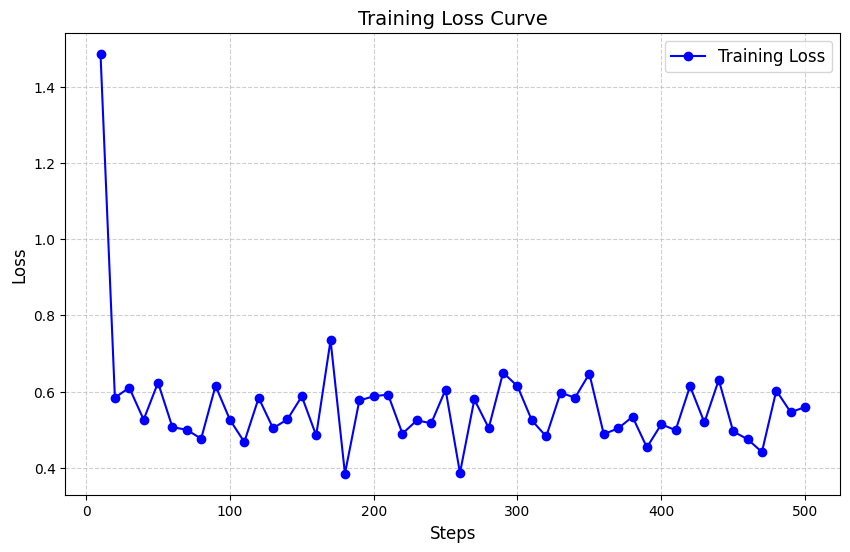

In [6]:
# Re-importing required libraries after environment reset
import matplotlib.pyplot as plt

# Data
steps = list(range(10, 501, 10))
losses = [
    1.486600, 0.583700, 0.610200, 0.526200, 0.623400, 0.506600, 0.499500, 0.476300,
    0.615100, 0.525900, 0.467500, 0.583300, 0.503700, 0.527000, 0.587300, 0.484700,
    0.734600, 0.384300, 0.576500, 0.587600, 0.592000, 0.489500, 0.524400, 0.516700,
    0.605100, 0.386300, 0.579200, 0.504300, 0.649600, 0.614000, 0.524200, 0.482100,
    0.597200, 0.583700, 0.646900, 0.488200, 0.503300, 0.533800, 0.453400, 0.514100,
    0.498500, 0.614100, 0.518800, 0.630700, 0.495300, 0.474900, 0.441300, 0.602500,
    0.545700, 0.559200
]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(steps, losses, marker='o', linestyle='-', color='b', label='Training Loss')
plt.title("Training Loss Curve", fontsize=14)
plt.xlabel("Steps", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.show()

In [ ]:
# Saving the model

model.save_pretrained("/content/drive/MyDrive/LoraModel") # Local saving
tokenizer.save_pretrained("/content/drive/MyDrive/LoraModel")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

('/content/drive/MyDrive/LoraModel/tokenizer_config.json',
 '/content/drive/MyDrive/LoraModel/special_tokens_map.json',
 '/content/drive/MyDrive/LoraModel/tokenizer.json')

# Inference

In [13]:
# Loading the model to run an inference and providing a manual input

max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

if True:
    from unsloth import FastLanguageModel
    finetuned_model, finetuned_tokenizer = FastLanguageModel.from_pretrained(
        model_name = "/content/drive/MyDrive/LoraModel", # YOUR MODEL YOU USED FOR TRAINING
        max_seq_length = 2048,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
    )
    FastLanguageModel.for_inference(finetuned_model) # Enable native 2x faster inference

# Tokenizing the input
inputs = finetuned_tokenizer(
[
    alpaca_prompt.format(
        """You are an advanced medical assistant designed to support medical students and doctors. Your primary purpose is to provide accurate, detailed, and evidence-based medical information. Your capabilities include
1. Explaining medical conditions, treatments, and procedures with a focus on detail and clinical relevance.
2. Assisting with differential diagnosis discussions by providing evidence-based insights.
3. Clarifying pharmacological mechanisms, drug interactions, and therapeutic guidelines.
4. Summarizing and interpreting medical research, guidelines, and studies.
5. Generating sample clinical cases or questions to support learning and examination preparation.
6. Providing insights into medical ethics, patient communication, and decision-making frameworks.


Please answer the letter of option truthfully""", # instruction
        """Q:The group that permits analysis of the entire natural history of HIV/AIDS is:?
        A:Persistent seronegatives;B:Long-term survivors;C:Seroconverters;D:Long-term survivors with low levels of CD4+ cells""", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

# Generating live output
from transformers import TextStreamer
text_streamer = TextStreamer(finetuned_tokenizer)
_ = finetuned_model.generate(**inputs, streamer = text_streamer, max_new_tokens = 2048)

==((====))==  Unsloth 2024.12.4: Fast Llama patching. Transformers:4.46.3.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 7.5. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
You are an advanced medical assistant designed to support medical students and doctors. Your primary purpose is to provide accurate, detailed, and evidence-based medical information. Your capabilities include
1. Explaining medical conditions, treatments, and procedures with a focus on detail and clinical relevance.
2. Assisting with differential diagn

# Evaluation

In [9]:
pip install matplotlib datasets bert-score evaluate rouge_score

In [10]:
# Loading the base and the finetuned model

# Initialize the original and fine-tuned models
original_model_name = "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit"  # Replace with original model path if needed
finetuned_model_path = "/content/drive/MyDrive/LoraModel"

# Load original model
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

original_model, original_tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    token = " ", # use one if using gated models like meta-llama/Llama-2-7b-hf
)
# original_model = AutoModelForCausalLM.from_pretrained(original_model_name, device_map="auto", load_in_4bit=True)
# original_tokenizer = AutoTokenizer.from_pretrained(original_model_name)

# Load fine-tuned model
finetuned_model, finetuned_tokenizer = FastLanguageModel.from_pretrained(
        model_name = "/content/drive/MyDrive/LoraModel", # YOUR MODEL YOU USED FOR TRAINING
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
    )

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2024.12.4: Fast Llama patching. Transformers:4.46.3.
   \\   /|    GPU: NVIDIA A100-SXM4-40GB. Max memory: 39.564 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 8.0. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/340 [00:00<?, ?B/s]

==((====))==  Unsloth 2024.12.4: Fast Llama patching. Transformers:4.46.3.
   \\   /|    GPU: NVIDIA A100-SXM4-40GB. Max memory: 39.564 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 8.0. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Unsloth 2024.12.4 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [11]:
# Setting up the loaded models for inference

FastLanguageModel.for_inference(original_model)
FastLanguageModel.for_inference(finetuned_model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 4096, padding_idx=128004)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lor

In [12]:
# Alpaca Prompt

alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

EOS_TOKEN = "<|eot_id|>"  # Make sure this matches the tokenizer's EOS token

In [66]:
# Pediction function
def predict_func(model, tokenizer, instruction, input_text):
    """Generate predictions using the Alpaca prompt."""
    # print(instruction)
    # print(input_text)

    # Adding end of the sentence token is giving empty predictions
    formatted_prompt = alpaca_prompt.format(instruction, input_text, "") + EOS_TOKEN
    inputs = tokenizer(formatted_prompt, return_tensors="pt").to("cuda")
    outputs = model.generate(**inputs, max_new_tokens=128, eos_token_id=tokenizer.eos_token_id)
    # print(outputs)
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    # print(response)

    if "### Response:" in response:
      response = response.split("### Response:")[1].strip()
      # print(response)
      return response
    else:
      response = response.strip()
      return response

# Making prediction and reference set
def make_prediction(dataset, model, tokenizer):
    predictions = []
    references = []
    for example in dataset:
        instruction = example["instruction"]
        input_text = example["input"]
        expected_output = example["output"]

        # Generate predictions
        predicted_output = predict_func(model, tokenizer, instruction, input_text)
        # print(predicted_output)
        # print(expected_output)
        predictions.append(predicted_output)
        references.append(expected_output)

    return predictions, references

In [34]:
# Loading data for evaluation

from datasets import load_dataset, DatasetDict

csv_file_path = '/content/drive/MyDrive/Med Dataset/prompts.csv'

dataset = load_dataset("csv", data_files=csv_file_path)

# Split the dataset into train (80%), validation (10%), and test (10%)
dataset_split = dataset["train"].train_test_split(test_size=0.2, seed=42)

# Further split the test set into validation (50%) and test (50%)
# validation_test_split = dataset_split["test"].train_test_split(test_size=0.5, seed=42)

# Combine the splits into a DatasetDict
final_splits = DatasetDict({
    "train": dataset_split["train"],
    "test": dataset_split["test"]
    # "validation": validation_test_split["train"],
    # "test": validation_test_split["test"]
})

In [64]:
# Making small test set for the project

test_subset = final_splits["test"].shuffle(seed=42).select(range(200))

In [65]:
len(test_subset)

200

In [61]:
# Finetuned model predictions

predictions_finetuned, references_finetuned = make_prediction(test_subset, finetuned_model, finetuned_tokenizer)





There is no cure for asthma, although symptoms sometimes improve over time. With proper self-management and medical treatment, most people with asthma can lead a normal life.







In [53]:
# Saving the finetuned model predictions

import json

# Specify the file path
output_file_path = "/content/drive/MyDrive/Med Dataset/finetuned_predictions_references.json"

# Combine predictions and references into a dictionary
output_data = {
    "predictions": predictions_finetuned,
    "references": references_finetuned
}

# Save to a JSON file
with open(output_file_path, "w") as file:
    json.dump(output_data, file, indent=4)

print(f"Saved predictions and references to {output_file_path}")

Saved predictions and references to /content/drive/MyDrive/Med Dataset/finetuned_predictions_references.json


In [67]:
# Base model predictions

predictions_original, references_original = make_prediction(test_subset, original_model, original_tokenizer)

In [68]:
# Saving the base model predictions

import json

# Specify the file path
output_file_path = "/content/drive/MyDrive/Med Dataset/original_predictions_references.json"

# Combine predictions and references into a dictionary
output_data = {
    "predictions": predictions_original,
    "references": references_original
}

# Save to a JSON file
with open(output_file_path, "w") as file:
    json.dump(output_data, file, indent=4)

print(f"Saved predictions and references to {output_file_path}")

Saved predictions and references to /content/drive/MyDrive/Med Dataset/original_predictions_references.json


In [47]:
# Printing the predictions

for (ref, pred) in zip(references_finetuned, predictions_finetuned):
  print(f"Reference: {ref}")
  print(f"Prediction: {pred}")

Reference: This is a strong advice
Prediction: This is no advice
Reference: In extrahepatic tissues, acetoacetate is activated to acetoacetyl-CoA via the enzyme thiophorase during ketone body metabolism.
Prediction: The product and enzyme involved in the activation of acetoacetate in extrahepatic tissues during ketone body metabolism is acetoacetyl-CoA and acetoacetate-CoA transferase.
Reference: Angiotensin-converting enzyme (ACE) converts angiotensin I to angiotensin II.
Prediction: The enzyme that converts angiotensin I to angiotensin II is angiotensin-converting enzyme (ACE).
Reference: Animal reproduction studies have shown fetal abnormalities in several species associated with hypervitaminosis D. These abnormalities are similar to the supravalvular aortic stenosis syndrome described in infants. The safety in excess of 400 USP Units of vitamin D daily during pregnancy has not been established.
Prediction: Animal reproduction studies have not been conducted on Ergocalciferol.
Refer

In [81]:
# Conducting Evaluation: ROGUE & BERT Score

import matplotlib.pyplot as plt
import evaluate
from bert_score import score as bert_score

# Metric loading
rouge_metric = evaluate.load("rouge")

def evaluate_model(predictions, references):
  # Calculate ROUGE
  rouge_results = rouge_metric.compute(predictions=predictions, references=references)

  # Calculate BERT Score
  # P, R, F1 = bert_score(predictions, references, lang="en", rescale_with_baseline=True)
  P, R, F1 = bert_score(predictions, references, model_type="bert-base-uncased", lang="en", rescale_with_baseline=True)
  bert_score_results = {
      "precision": P.mean().item(),
      "recall": R.mean().item(),
      "f1": F1.mean().item(),
  }

  return {
      "rouge": rouge_results,
      "bert_score": bert_score_results,
  }

In [3]:
import json

# Function to read the JSON file and return predictions and references
def load_predictions_and_references(file_path):
    with open(file_path, "r") as file:
        data = json.load(file)
    return data["predictions"], data["references"]

# File paths for original and finetuned predictions
original_predictions_file = "/content/drive/MyDrive/Med Dataset/original_predictions_references.json"
finetuned_predictions_file = "/content/drive/MyDrive/Med Dataset/finetuned_predictions_references.json"

# Load predictions and references for the original model
predictions_original, references_original = load_predictions_and_references(original_predictions_file)

# Load predictions and references for the finetuned model
predictions_finetuned, references_finetuned = load_predictions_and_references(finetuned_predictions_file)

In [78]:
print(predictions_finetuned[:10])
print(references_finetuned[:10])

['This is a weak advice', 'The product and enzyme involved in the activation of acetoacetate in extrahepatic tissues during ketone body metabolism are acetoacetyl-CoA and acetoacetate-CoA.', 'The enzyme that converts angiotensin I to angiotensin II is angiotensin-converting enzyme (ACE).', 'No reproductive studies have been conducted on Ergocalciferol.', 'Asthma is a disease that causes the airways of the lungs to swell and narrow. It leads to wheezing, shortness of breath, chest tightness, and coughing. Asthma is caused by swelling (inflammation) in the airways. When an asthma attack occurs, the lining of the air passages swells and the muscles surrounding the airways become tight. This reduces the amount of air that can pass through the airway. In people who have sensitive airways, asthma symptoms can be triggered by breathing in substances called allergens or triggers. Common asthma triggers include: Animals (pet hair or dander) Dust mites Certain medicines (aspirin and other NSAIDS

In [5]:
from sklearn.metrics import f1_score

# Calculate the F1 score
f1_finetuned = f1_score(references_finetuned, predictions_finetuned, average='micro')
f1_original = f1_score(references_original, predictions_original, average='micro')

print("F1 finetuned score:", f1_finetuned)
print("F1 original score:", f1_original)

F1 finetuned score: 0.185
F1 original score: 0.0


In [79]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
predictions_finetuned = [tokenizer.tokenize(text) for text in predictions_finetuned]
references_finetuned = [tokenizer.tokenize(text) for text in references_finetuned]

predictions_original = [tokenizer.tokenize(text) for text in predictions_original]
references_original = [tokenizer.tokenize(text) for text in references_original]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [82]:
# Evaluating the original and fine-tuned models

original_results = evaluate_model(predictions_original, references_original)
finetuned_results = evaluate_model(predictions_finetuned, references_finetuned)

ValueError: Predictions and/or references don't match the expected format.
Expected format:
Feature option 0: {'predictions': Value(dtype='string', id='sequence'), 'references': Sequence(feature=Value(dtype='string', id='sequence'), length=-1, id=None)}
Feature option 1: {'predictions': Value(dtype='string', id='sequence'), 'references': Value(dtype='string', id='sequence')},
Input predictions: ['assistant', 'this', 'is', ..., 'of', 'advice', '.'],
Input references: ['this', 'is', 'a', 'strong', 'advice']

In [75]:
def print_results(original_results, finetuned_results):
  print("Evaluation Results:\n")

  rouge_keys = ["rouge1", "rouge2", "rougeL"]
  bert_keys = ["precision", "recall", "f1"]

  # Original Model Results
  print("Original Model Results:")
  for metric, value in original_results.items():
      if metric == "rouge":
          print("ROUGE Metrics:")
          for key in rouge_keys:
              print(f"  {key}: {value[key]:.4f}")
      elif metric == "bert_score":
          print("BERT Metrics:")
          for key in bert_keys:
              print(f"  {key}: {value[key]:.4f}")
      else:
          print(f"{metric}: {value:.4f}")

  # Finetuned Model Results
  print("\nFinetuned Model Results:")
  for metric, value in finetuned_results.items():
      if metric == "rouge":
          print("ROUGE Metrics:")
          for key in rouge_keys:
              print(f"  {key}: {value[key]:.4f}")
      elif metric == "bert_score":
          print("BERT Metrics:")
          for key in bert_keys:
              print(f"  {key}: {value[key]:.4f}")
      else:
          print(f"{metric}: {value:.4f}")

  # Comparison of Results
  print("\nComparison:")
  for metric in original_results.keys():
      original_value = original_results[metric]
      finetuned_value = finetuned_results[metric]

      if metric == "rouge":
          print("ROUGE Metrics:")
          for key in rouge_keys:
              improvement = finetuned_value[key] - original_value[key]
              print(f"  {key} Improvement: {improvement:.4f}")
      elif metric == "bert_score":
          print("BERT Metrics:")
          for key in bert_keys:
              improvement = finetuned_value[key] - original_value[key]
              print(f"  {key} Improvement: {improvement:.4f}")
      else:
          improvement = finetuned_value - original_value
          print(f"{metric} Improvement: {improvement:.4f}")

In [72]:
print_results(original_results, finetuned_results)

Evaluation Results:

Original Model Results:
ROUGE Metrics:
  rouge1: 0.2172
  rouge2: 0.0839
  rougeL: 0.1540
BERT Metrics:
  precision: -0.0497
  recall: 0.1741
  f1: 0.0580

Finetuned Model Results:
ROUGE Metrics:
  rouge1: 0.0103
  rouge2: 0.0000
  rougeL: 0.0074
BERT Metrics:
  precision: -4.4196
  recall: -4.4401
  f1: -4.4212

Comparison:
ROUGE Metrics:
  rouge1 Improvement: -0.2069
  rouge2 Improvement: -0.0839
  rougeL Improvement: -0.1467
BERT Metrics:
  precision Improvement: -4.3699
  recall Improvement: -4.6142
  f1 Improvement: -4.4792


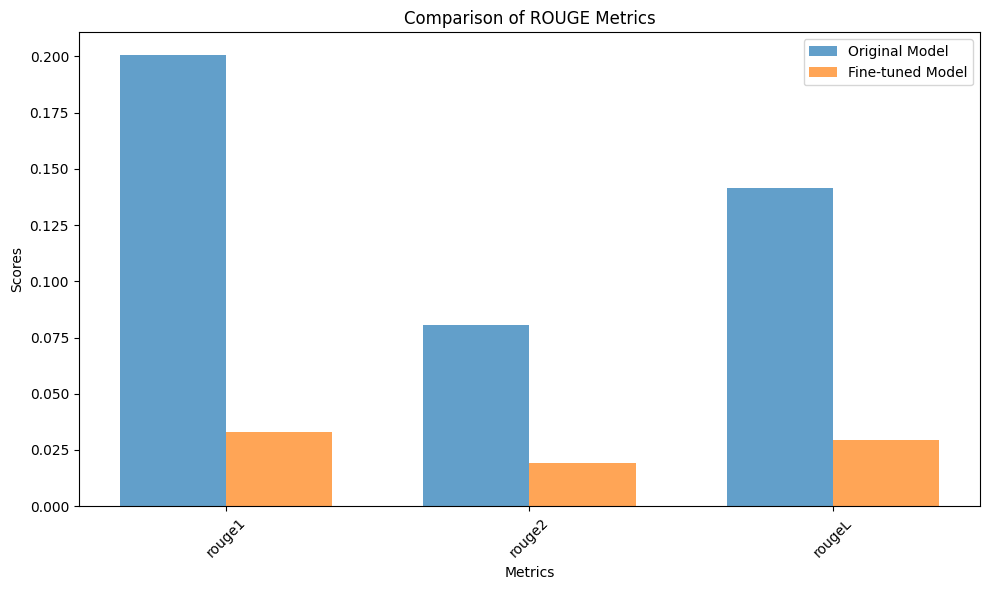

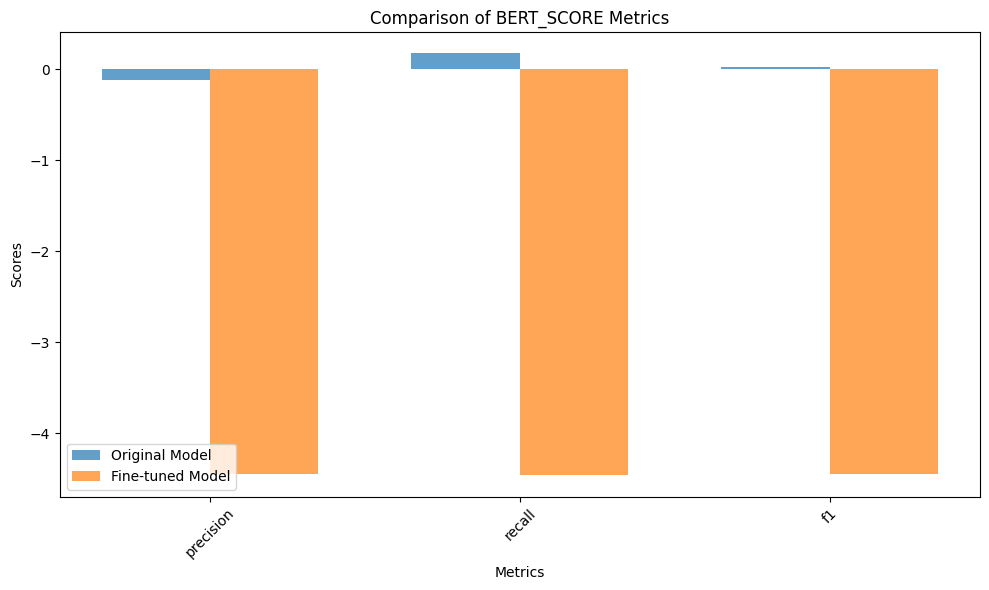

In [18]:
# Compare results
def plot_comparison(original, finetuned, metric, metric_keys):
    """Plot comparison charts."""
    original_scores = [original[key] for key in metric_keys]
    finetuned_scores = [finetuned[key] for key in metric_keys]

    bar_width = 0.35
    x = range(len(metric_keys))

    plt.figure(figsize=(10, 6))
    plt.bar(x, original_scores, width=bar_width, label="Original Model", alpha=0.7)
    plt.bar([i + bar_width for i in x], finetuned_scores, width=bar_width, label="Fine-tuned Model", alpha=0.7)

    plt.xlabel("Metrics")
    plt.ylabel("Scores")
    plt.title(f"Comparison of {metric.upper()} Metrics")
    plt.xticks([i + bar_width / 2 for i in x], metric_keys, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
# Plot ROUGE comparison
rouge_keys = ["rouge1", "rouge2", "rougeL"]
plot_comparison(original_results["rouge"], finetuned_results["rouge"], "rouge", rouge_keys)

# Plot BERT Score comparison
bert_keys = ["precision", "recall", "f1"]
plot_comparison(original_results["bert_score"], finetuned_results["bert_score"], "bert_score", bert_keys)